## Exploratory Data Analysis of RNA Expression Data
This notebook is intended to compute some summary statistics and charts of the RNA expression data table as passed to the Open Targets team by Expression Atlas. The table is a matrix of normalised RPKM values where each column is a tissue and each row is a gene.

In [1]:
%matplotlib inline

### Imports

In [2]:
import numpy as np
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

### Load the data file

In [3]:
expression = DataFrame.from_csv('expression.txt', sep='\t')

### Heatmap
Below is a heatmap of the RNA data after the following logarithmic transform:
```
x => log(x + 1)
```

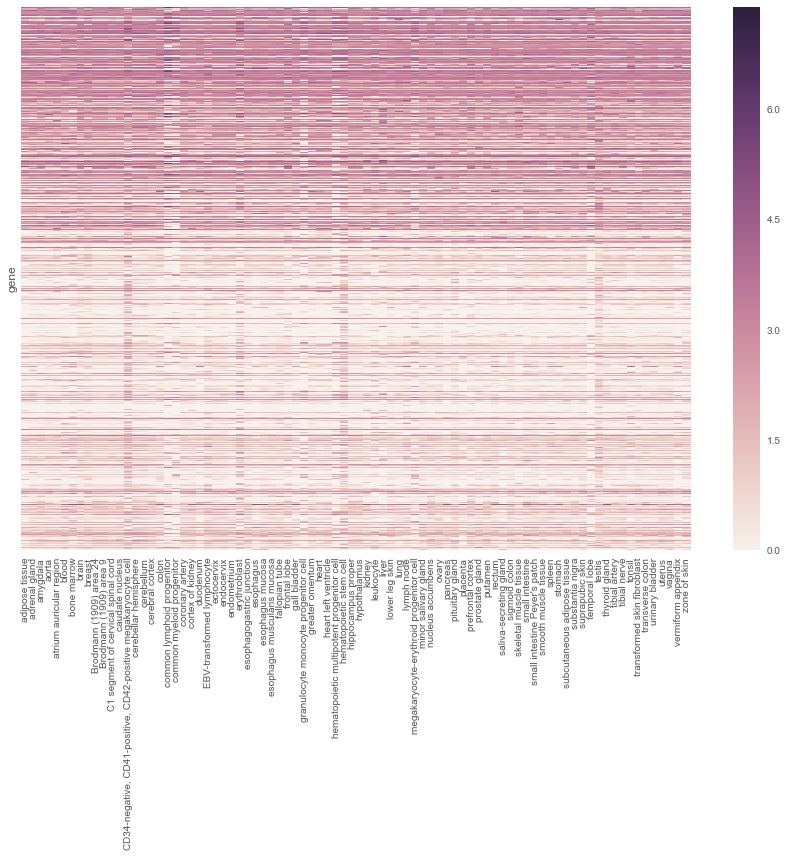

In [4]:
log_expression = np.log10(expression + 1)
plt.figure(figsize=(15, 10))
sns.heatmap(log_expression, yticklabels=False)
plt.show()

### Apply a threshold
Expression Atlas suggested applying a threshold of between 2 and 8, so 6 was chosen.

In [5]:
threshold = np.log10(6)
threshold_log_expression = log_expression[log_expression > threshold]

### Reshape to one-dimensional array

In [6]:
flat_expression = expression.values.flatten()
flat_log_expression = log_expression.values.flatten()
flat_threshold_log_expression = threshold_log_expression.values.flatten()

# filter nans
flat_threshold_log_expression = flat_threshold_log_expression[~np.isnan(flat_threshold_log_expression)]

### Plot a histogram and calculate levels
Possible 10-level calculation schemes include:
* deciles
* division of the log expression range into ten portions (effectively the histogram buckets below)

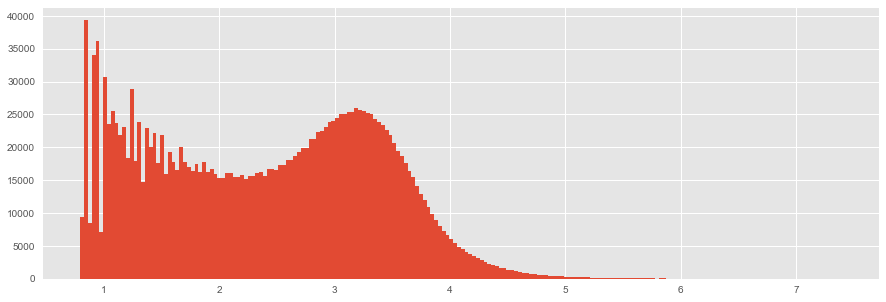

In [7]:
plt.figure(figsize=(15, 5))
plt.hist(flat_threshold_log_expression, bins=200)
plt.show()

### Check distribution per tissue
The following boxplot shows the distribution of values per tissue.

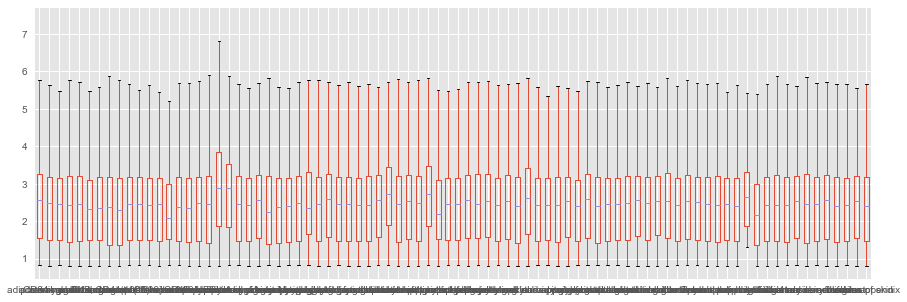

In [8]:
plt.figure()
threshold_log_expression.plot.box(figsize=(15, 5))
plt.show()

### Check distribution per gene
There are too many genes for an equivalent to the above, but histograms of some summary statistics (per gene) should give a sense of the distributions. They are much more variable than the per tissue distributions.

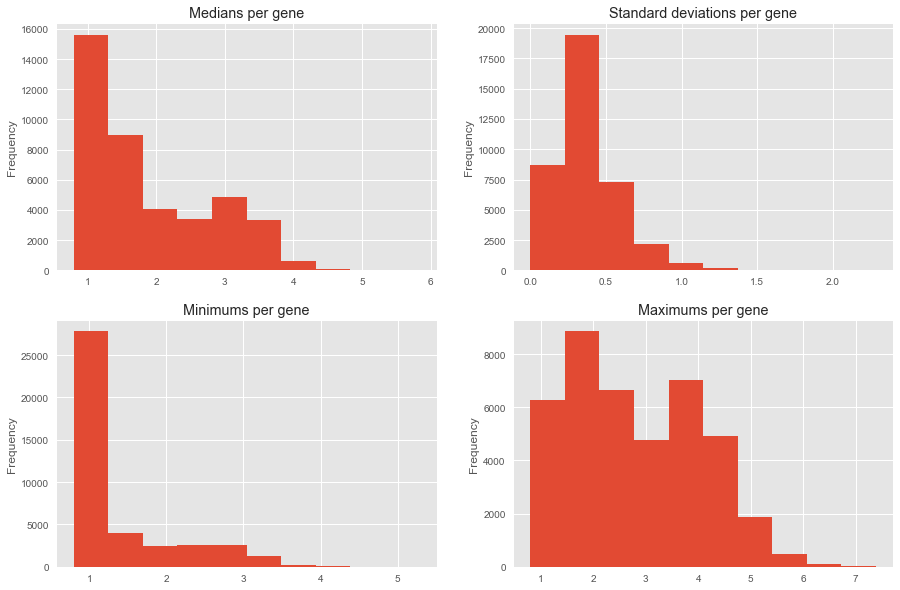

In [9]:
medians = threshold_log_expression.T.median()
stds = threshold_log_expression.T.std()
mins = threshold_log_expression.T.min()
maxs = threshold_log_expression.T.max()

plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.title('Medians per gene')
medians.plot.hist()

plt.subplot(222)
plt.title('Standard deviations per gene')
stds.plot.hist()

plt.subplot(223)
plt.title('Minimums per gene')
mins.plot.hist()

plt.subplot(224)
plt.title('Maximums per gene')
maxs.plot.hist()

plt.show()

### Generate buckets using the threshold log method
Create ten buckets of equal width (in the `log(RPKM + 1)` axis). Note that this means the buckets will not have equal numbers of entries (ie. unlike deciles).

In [10]:
hist_counts, bin_edges = np.histogram(flat_threshold_log_expression)
print(hist_counts)
print(bin_edges)

[452206 343345 339683 482725 259848  42178   6013   1259    243     27]
[ 0.79588002  1.45530387  2.11472771  2.77415156  3.43357541  4.09299926
  4.75242311  5.41184696  6.0712708   6.73069465  7.3901185 ]


[ 0  1  2  3  4  5  6  7  8  9 10]
[1677417  452206  343345  339683  482725  259848   42178    6013    1259
     243      27]


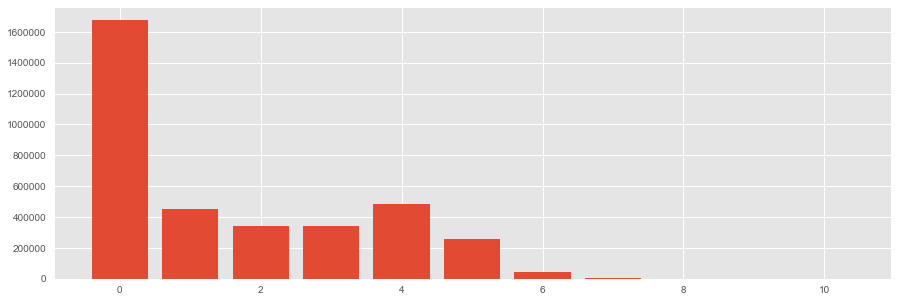

In [11]:
threshold_log_levels = DataFrame(data=np.digitize(np.nan_to_num(threshold_log_expression), bin_edges[:-1]),
                                 index=expression.index,
                                 columns=expression.columns)
# How many items per bin?
uniq, counts = np.unique(threshold_log_levels.values.flatten(), return_counts=True)
print(uniq)
print(counts)
plt.figure(figsize=(15, 5))
plt.bar(uniq, counts)
plt.show()

### Generate buckets using the deciles method
Create ten buckets using deciles.

[ 0  1  2  3  4  5  6  7  8  9 10]
[1677417  188929  195783  191850  194248  192862  192794  192751  192755
  192787  192768]


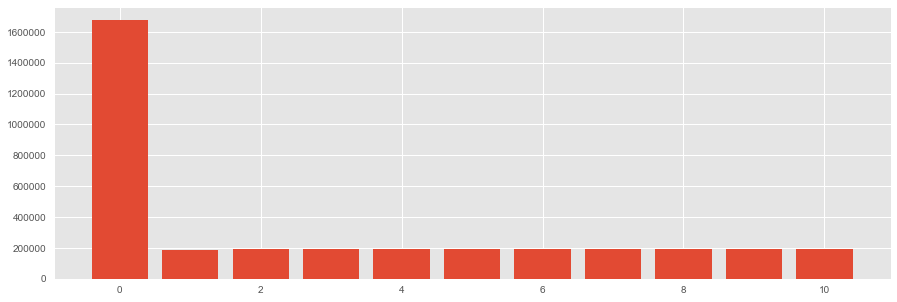

In [12]:
deciles = np.percentile(flat_threshold_log_expression, np.arange(0, 101, 10))
decile_levels = DataFrame(data=np.digitize(np.nan_to_num(threshold_log_expression), deciles[:-1]),
                          index=expression.index,
                          columns=expression.columns)
# How many items per bin?
uniq, counts = np.unique(decile_levels.values.flatten(), return_counts=True)
print(uniq)
print(counts)
plt.figure(figsize=(15, 5))
plt.bar(uniq, counts)
plt.show()

### Look at specific gene profiles
This is what is eventually displayed on the RNA baseline expression widget. The following genes have been identified as interesting:
* OPALIN: ENSG00000197430
* MB: ENSG00000198125
* IL5: ENSG00000113525

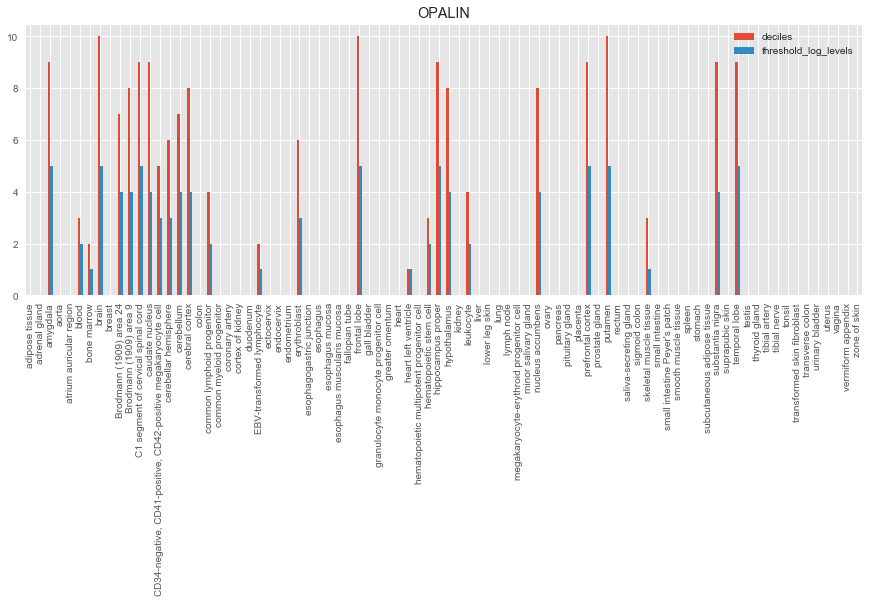

In [13]:
opalin_comparison = DataFrame({'deciles': decile_levels.T['ENSG00000197430'],
                               'threshold_log_levels': threshold_log_levels.T['ENSG00000197430']})
plt.figure(figsize=(15, 5))
opalin_comparison.plot.bar(title='OPALIN', figsize=(15, 5))
plt.show()

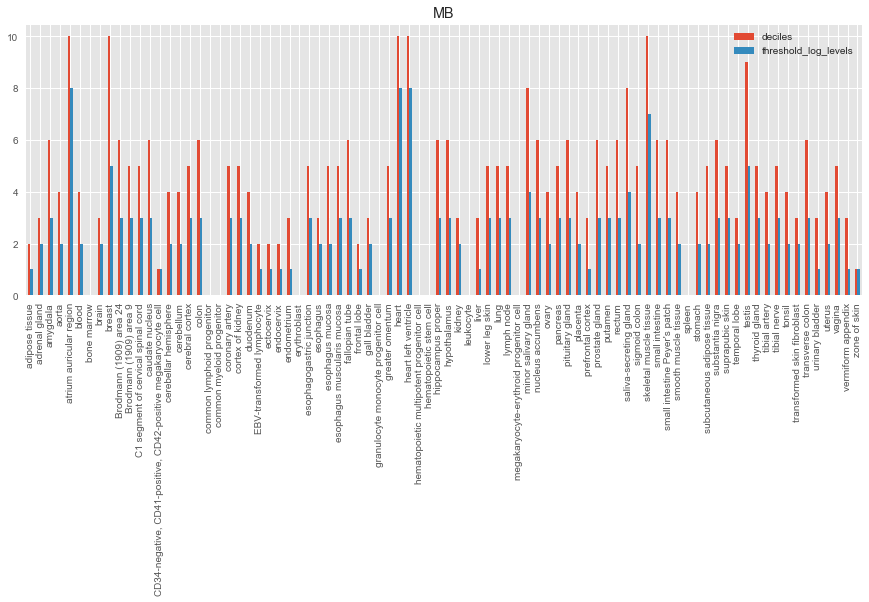

In [14]:
mb_comparison = DataFrame({'deciles': decile_levels.T['ENSG00000198125'],
                           'threshold_log_levels': threshold_log_levels.T['ENSG00000198125']})
plt.figure(figsize=(15, 5))
mb_comparison.plot.bar(title='MB', figsize=(15, 5))
plt.show()

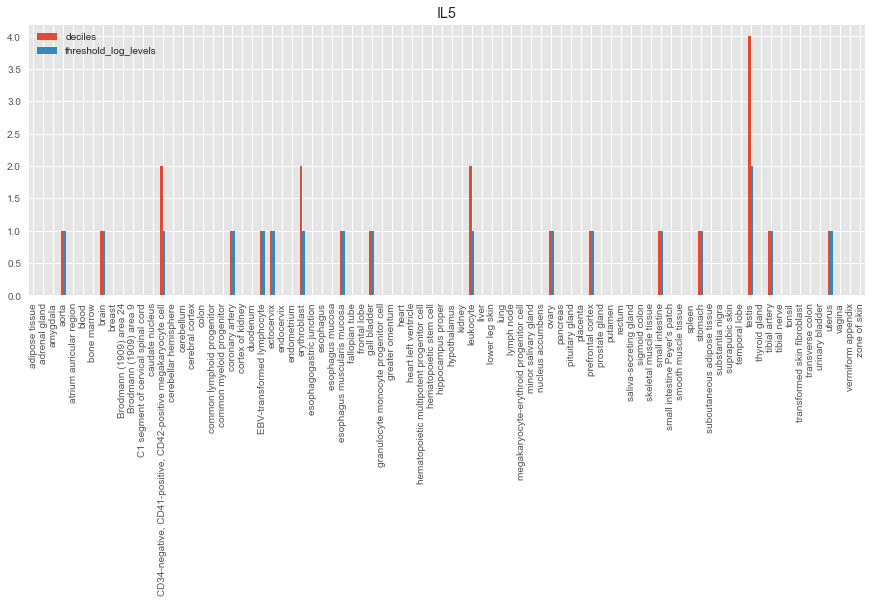

In [15]:
il5_comparison = DataFrame({'deciles': decile_levels.T['ENSG00000113525'],
                            'threshold_log_levels': threshold_log_levels.T['ENSG00000113525']})
plt.figure(figsize=(15, 5))
il5_comparison.plot.bar(title='IL5', figsize=(15, 5))
plt.show()

### How linked are pairs of tissues and pairs of genes?

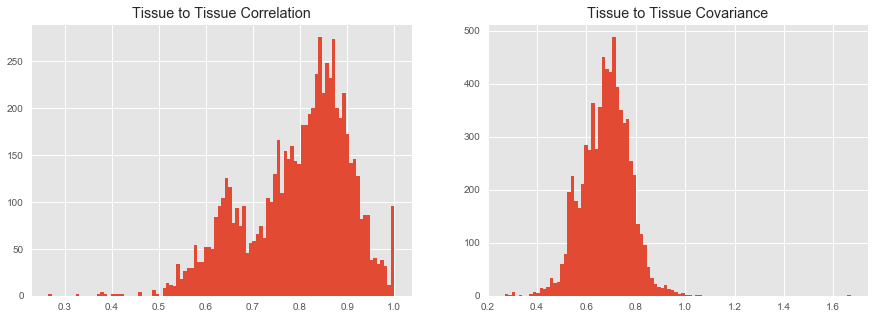

In [16]:
tissue_corr = threshold_log_expression.corr()
tissue_cov = threshold_log_expression.cov()
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.title('Tissue to Tissue Correlation')
plt.hist(tissue_corr.values.flatten(), bins=100)

plt.subplot(122)
plt.title('Tissue to Tissue Covariance')
plt.hist(tissue_cov.values.flatten(), bins=100)

plt.show()

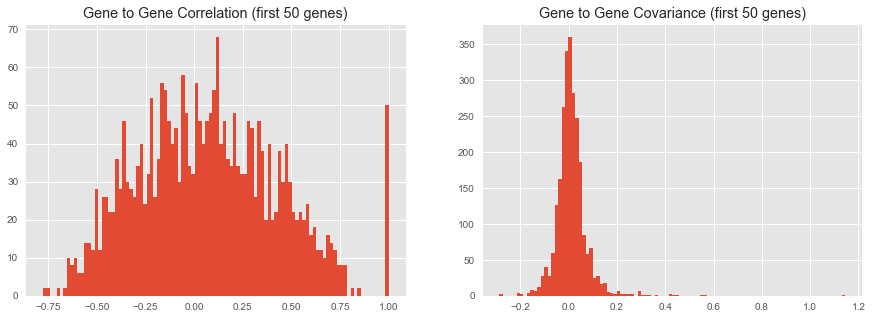

In [17]:
# There are too many gene-gene comparisons to complete in a reasonable time,
# so pick the first 50 genes and just do pairwise comparisons on those.
gene_subset = threshold_log_expression.head(n=50)
gene_corr = gene_subset.T.corr()
gene_cov = gene_subset.T.cov()
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.title('Gene to Gene Correlation (first 50 genes)')
plt.hist(gene_corr.values.flatten(), bins=100)

plt.subplot(122)
plt.title('Gene to Gene Covariance (first 50 genes)')
plt.hist(gene_cov.values.flatten(), bins=100)

plt.show()

## Tissue-Specificity Metrics
There are multiple ways to calculate tissue-specificity per gene and this [paper](https://academic.oup.com/bib/article/18/2/205/2562739/A-benchmark-of-gene-expression-tissue-specificity) offers a comparison. Based on their recommendation, the tau method is calculated below. However, this gives a single value per gene, which is not ideal for faceting (since we don't then know which tissue is responsible for a strong specificity). Some other methods (such as z-score) are therefore also calculated.

In [19]:
# x_hat is an intermediate step and gives a normalised value per gene-tissue cell
# (tau is per gene; ie. an aggregation occurs across tissues)
gene_maxes = log_expression.T.max()
normaliser = DataFrame(data=[gene_maxes.values] * len(log_expression.columns),
                       index=expression.columns,
                       columns=expression.index)
x_hat = log_expression / normaliser.T
tau = x_hat.T.apply(lambda x: 1 - x).sum() / log_expression.shape[1]

### Tissue-specificity by tau
To view the sorted list, call the following:
```
print(tau.sort_values())
```
A couple of the top gene hits by tau value are listed below, and looking at their GTEx profile shows very small absolute values, with one pronounced tissue, which is exactly the case we looked for in IL5.
* ENSG00000187545 = PRAMEF10
* ENSG00000166351 = POTED

Below is a histogram of the tau value across all genes.

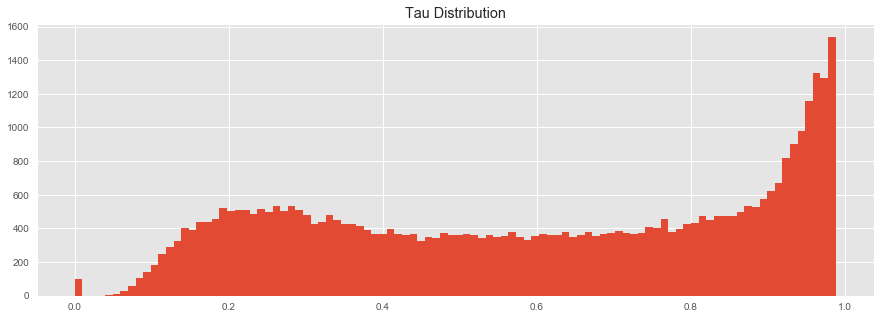

In [20]:
plt.figure(figsize=(15, 5))
plt.title('Tau Distribution')
plt.hist(tau.values.flatten(), bins=100)
plt.show()

### Tissue-specificity by gini
TODO

### Tissue-specificity by z-score
The z-score is calculcated as `z = x - mu / sigma` where `mu` is the mean of gene expression, `sigma` is the standard deviation.

In [42]:
mu = log_expression.T.mean()
sigma = log_expression.T.std()
df_mu = DataFrame(data=[mu.values] * len(log_expression.columns),
                  index=expression.columns,
                  columns=expression.index)
df_sigma = DataFrame(data=[sigma.values] * len(log_expression.columns),
                     index=expression.columns,
                     columns=expression.index)
z = (log_expression - df_mu.T) / df_sigma.T

8484


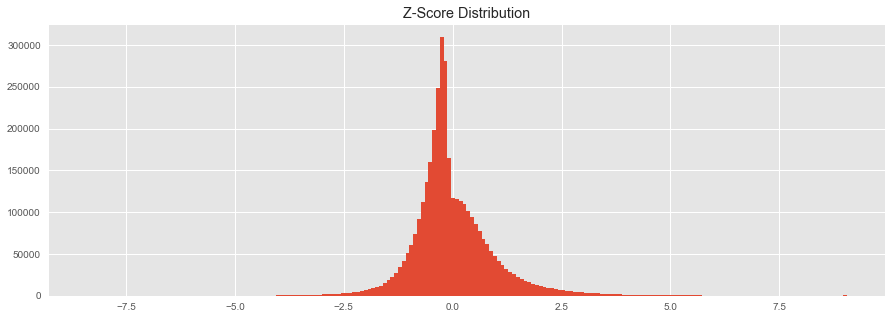

In [44]:
all_z = z.values.flatten()
all_z_no_nans = all_z[~np.isnan(all_z)]

# How many NaNs?
print(len(all_z) - len(all_z_no_nans))

plt.figure(figsize=(15, 5))
plt.title('Z-Score Distribution')
plt.hist(all_z_no_nans, bins=200)
plt.show()

3.45753535028
testis                                                            3.457535
erythroblast                                                      2.229950
leukocyte                                                         1.758143
CD34-negative, CD41-positive, CD42-positive megakaryocyte cell    1.658629
small intestine                                                   1.492613
EBV-transformed lymphocyte                                        1.300963
tibial artery                                                     1.300963
aorta                                                             1.154527
uterus                                                            1.154527
brain                                                             1.074289
Name: ENSG00000113525, dtype: float64


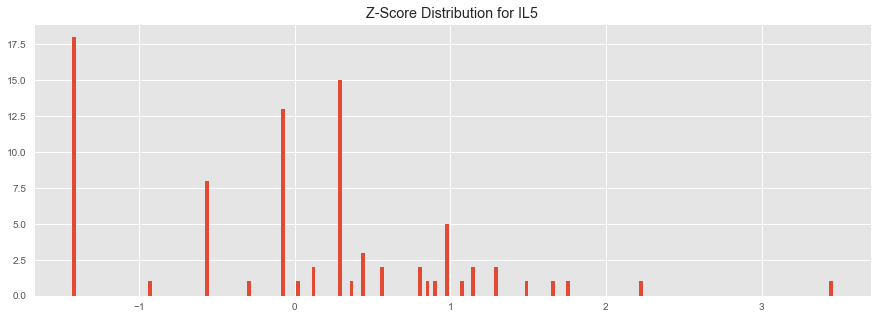

In [56]:
# Is IL5 specifically expressed in testis?
print(z.T['ENSG00000113525'].sort_values(ascending=False).head(n=10))

plt.figure(figsize=(15, 5))
plt.title('Z-Score Distribution for IL5')
plt.hist(z.T['ENSG00000113525'], bins=200)
plt.show()

frontal lobe                          2.255047
putamen                               2.025573
brain                                 2.008107
hippocampus proper                    1.977441
amygdala                              1.974612
prefrontal cortex                     1.972553
temporal lobe                         1.965650
C1 segment of cervical spinal cord    1.879697
caudate nucleus                       1.814639
substantia nigra                      1.814058
Name: ENSG00000197430, dtype: float64


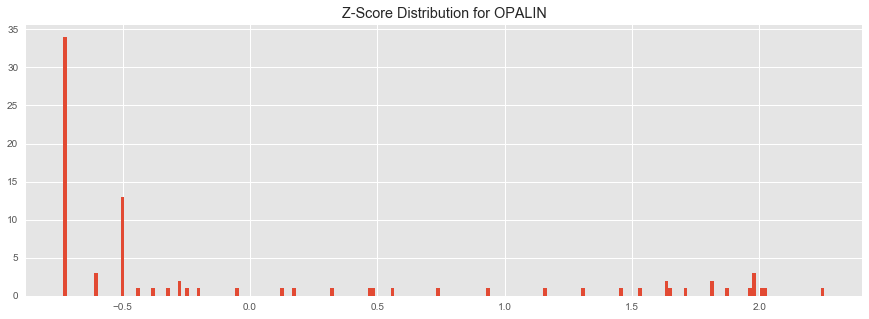

In [57]:
# Is OPALIN specifically expressed in brain?
print(z.T['ENSG00000197430'].sort_values(ascending=False).head(n=10))

plt.figure(figsize=(15, 5))
plt.title('Z-Score Distribution for OPALIN')
plt.hist(z.T['ENSG00000197430'], bins=200)
plt.show()

atrium auricular region    3.150567
heart left ventricle       3.114737
heart                      3.084188
skeletal muscle tissue     2.685397
breast                     1.723645
testis                     1.328292
minor salivary gland       1.060661
saliva-secreting gland     1.027734
pituitary gland            0.661554
prostate gland             0.617690
Name: ENSG00000198125, dtype: float64


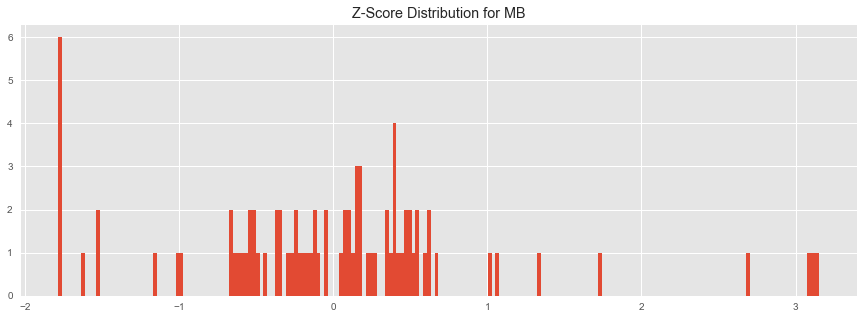

In [59]:
# Is MB specifically expressed in heart and muscle?
print(z.T['ENSG00000198125'].sort_values(ascending=False).head(n=10))

plt.figure(figsize=(15, 5))
plt.title('Z-Score Distribution for MB')
plt.hist(z.T['ENSG00000198125'], bins=200)
plt.show()

### Save to file
Store the tau and z-score values

In [62]:
tau.to_csv('tau.tsv', sep='\t')
z.to_csv('z-score.tsv', sep='\t')